In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, RobustScaler, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import xgboost as xgb

In [ ]:
def evaluate_model(model, X_train, y_train, X_test, y_test, class_names=None):
  print("The training set:")
  y_train_pred = model.predict(X_train)
  print("\n Validation accuracy: ", accuracy_score(y_train, y_train_pred))
  print("\n Classification report:\n ",classification_report(y_train, y_train_pred))
  print("\n Confusion matrix:\n", confusion_matrix(y_train, y_train_pred))

  print("\nThe test set:")
  y_test_pred = model.predict(X_test)
  print("\n Validation accuracy: ", accuracy_score(y_test, y_test_pred))
  print("\n Classification report:\n ",classification_report(y_test, y_test_pred))
  print("\n Confusion matrix: \n", confusion_matrix(y_test, y_test_pred))

  # ---- ROC Curve ----
  classes = model.classes_
  n_classes = len(classes)
  y_test_bin = label_binarize(y_test, classes=classes)
  y_score = model.predict_proba(X_test)

  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

  plt.figure(figsize=(7,6))
  colors = plt.cm.get_cmap('Set1', n_classes)
  for i in range(n_classes):
    label = f"Class {i}" if class_names is None else class_names[i]
    plt.plot(fpr[i], tpr[i], color=colors(i), lw=2, label=f'{label} (AUC = {roc_auc[i]:.2f})')

  plt.plot([0,1], [0,1], 'k--', lw=1)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Multi-class ROC Curve')
  plt.legend(loc='lower right')
  plt.grid(True)
  plt.show()

In [ ]:
# load data
IIn = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML_Fall2025_Supernovae/supernova_parameters_successful.csv')
II = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML_Fall2025_Supernovae/supernova_parameters_successful[68].csv')
Ia = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML_Fall2025_Supernovae/supernova_parameters_successful[75].csv')

Attempt 1: Original data

In [ ]:
data = pd.concat([IIn, II, Ia], ignore_index=True)
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

skip = {'supernova', 'type', 'band', 'n_obs', 'flux_scale', 'redshift'}
feature_cols = [c for c in data.columns if c not in skip]

# features
X = data[feature_cols]

Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

X = X.clip(lower=lower, upper=upper, axis=1)

# labels
y = data['type']
y = y.map({'IIn': 0, 'II': 1, 'Ia': 2})

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1, 2]),
    y=y
)

class_weights_dict = dict(enumerate(class_weights))

# get mapping for checking
print("Unique mapped labels:", y.unique())

# count examples in classes
pd.Series(y).value_counts()

Unique mapped labels: [2 1 0]


,count
type,
2,10708
1,1183
0,276


In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y,
    shuffle=True
)

scaler = RobustScaler()
X_train1 = scaler.fit_transform(X_train1)
X_test1 = scaler.transform(X_test1)

In [ ]:
model1 = xgb.XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss'
)

model1.fit(
    X_train1, y_train1,
    eval_set=[(X_test1, y_test1)]
)

[0]	validation_0-mlogloss:0.70353
[1]	validation_0-mlogloss:0.68086
[2]	validation_0-mlogloss:0.65982
[3]	validation_0-mlogloss:0.64007
[4]	validation_0-mlogloss:0.62147
[5]	validation_0-mlogloss:0.60380
[6]	validation_0-mlogloss:0.58722
[7]	validation_0-mlogloss:0.57203
[8]	validation_0-mlogloss:0.55776
[9]	validation_0-mlogloss:0.54434
[10]	validation_0-mlogloss:0.53162
[11]	validation_0-mlogloss:0.51965
[12]	validation_0-mlogloss:0.50835
[13]	validation_0-mlogloss:0.49782
[14]	validation_0-mlogloss:0.48766
[15]	validation_0-mlogloss:0.47829
[16]	validation_0-mlogloss:0.46946
[17]	validation_0-mlogloss:0.46082
[18]	validation_0-mlogloss:0.45296
[19]	validation_0-mlogloss:0.44535
[20]	validation_0-mlogloss:0.43811
[21]	validation_0-mlogloss:0.43162
[22]	validation_0-mlogloss:0.42526
[23]	validation_0-mlogloss:0.41907
[24]	validation_0-mlogloss:0.41312
[25]	validation_0-mlogloss:0.40752
[26]	validation_0-mlogloss:0.40221
[27]	validation_0-mlogloss:0.39716
[28]	validation_0-mlogloss:0.3

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None, num_class=3, ...)

The training set:

 Validation accuracy:  0.9520189047570122

 Classification report:
                precision    recall  f1-score   support

           0       0.98      0.53      0.69       221
           1       0.94      0.64      0.76       946
           2       0.95      1.00      0.97      8566

    accuracy                           0.95      9733
   macro avg       0.96      0.72      0.81      9733
weighted avg       0.95      0.95      0.95      9733


 Confusion matrix:
 [[ 118   14   89]
 [   1  606  339]
 [   1   23 8542]]

The test set:

 Validation accuracy:  0.8972884141331142

 Classification report:
                precision    recall  f1-score   support

           0       0.86      0.11      0.19        55
           1       0.60      0.30      0.40       237
           2       0.91      0.98      0.95      2142

    accuracy                           0.90      2434
   macro avg       0.79      0.47      0.51      2434
weighted avg       0.88      0.90      0.88 

/tmp/ipython-input-1736215833.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


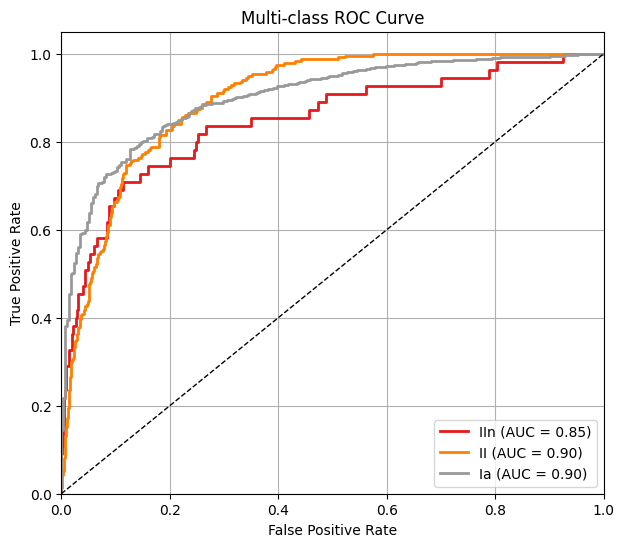

In [ ]:
evaluate_model(model1, X_train1, y_train1, X_test1, y_test1, ["IIn","II","Ia"])

Attempt 2: Downsampling

In [ ]:
Ia_down = Ia.sample(4000)

data_down = pd.concat([IIn, II, Ia_down], ignore_index=True)
data_down = data_down.sample(frac=1, random_state=42).reset_index(drop=True)

# features
X_down = data_down[feature_cols]

Q1 = X_down.quantile(0.25)
Q3 = X_down.quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

X_down = X_down.clip(lower=lower, upper=upper, axis=1)

# labels
y_down = data_down['type']
y_down = y_down.map({'IIn': 0, 'II': 1, 'Ia': 2})

# get mapping for checking
print("Unique mapped labels:", y_down.unique())

# count examples in classes
pd.Series(y_down).value_counts()

Unique mapped labels: [2 1 0]


,count
type,
2,4000
1,1183
0,276


In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X_down, y_down,
    test_size=0.2,
    random_state=42,
    stratify=y_down,
    shuffle=True
)

scaler = RobustScaler()
X_train2 = scaler.fit_transform(X_train2)
X_test2 = scaler.transform(X_test2)

In [ ]:
model2 = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss'
)

model2.fit(
    X_train2, y_train2,
    eval_set=[(X_test2, y_test2)]
)

[0]	validation_0-mlogloss:0.86796
[1]	validation_0-mlogloss:0.84770
[2]	validation_0-mlogloss:0.82964
[3]	validation_0-mlogloss:0.81176
[4]	validation_0-mlogloss:0.79551
[5]	validation_0-mlogloss:0.78003
[6]	validation_0-mlogloss:0.76559
[7]	validation_0-mlogloss:0.75180
[8]	validation_0-mlogloss:0.73906
[9]	validation_0-mlogloss:0.72735
[10]	validation_0-mlogloss:0.71617
[11]	validation_0-mlogloss:0.70579
[12]	validation_0-mlogloss:0.69599
[13]	validation_0-mlogloss:0.68609
[14]	validation_0-mlogloss:0.67695
[15]	validation_0-mlogloss:0.66921
[16]	validation_0-mlogloss:0.66149
[17]	validation_0-mlogloss:0.65317
[18]	validation_0-mlogloss:0.64605
[19]	validation_0-mlogloss:0.63874
[20]	validation_0-mlogloss:0.63222
[21]	validation_0-mlogloss:0.62615
[22]	validation_0-mlogloss:0.62032
[23]	validation_0-mlogloss:0.61432
[24]	validation_0-mlogloss:0.60891
[25]	validation_0-mlogloss:0.60362
[26]	validation_0-mlogloss:0.59912
[27]	validation_0-mlogloss:0.59364
[28]	validation_0-mlogloss:0.5

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None, num_class=3, ...)

The training set:

 Validation accuracy:  0.9326768948935196

 Classification report:
                precision    recall  f1-score   support

           0       0.99      0.60      0.75       221
           1       0.91      0.84      0.87       946
           2       0.94      0.98      0.96      3200

    accuracy                           0.93      4367
   macro avg       0.95      0.81      0.86      4367
weighted avg       0.93      0.93      0.93      4367


 Confusion matrix:
 [[ 132   30   59]
 [   0  790  156]
 [   1   48 3151]]

The test set:

 Validation accuracy:  0.8058608058608059

 Classification report:
                precision    recall  f1-score   support

           0       0.43      0.05      0.10        55
           1       0.61      0.55      0.58       237
           2       0.86      0.93      0.89       800

    accuracy                           0.81      1092
   macro avg       0.63      0.51      0.52      1092
weighted avg       0.78      0.81      0.79 

/tmp/ipython-input-1736215833.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


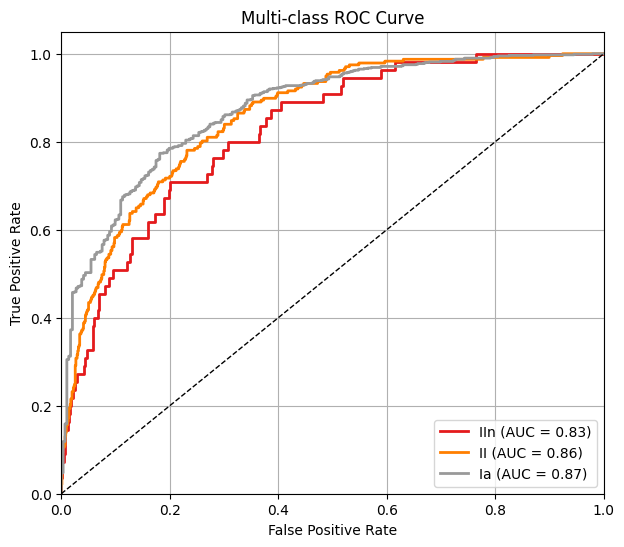

In [ ]:
evaluate_model(model2, X_train2, y_train2, X_test2, y_test2, ["IIn","II","Ia"])